In [1]:
import torch
print(torch.__version__)

2.5.0+cu121


In [2]:
!python --version

Python 3.10.12


In [3]:
!rm -rf /content/bert_imb

# <font color = 'indianred'>**Multilabel Classification of StackExchange Dataset using DistilBert** </font>

**Objective:**

In this notebook, we aim to build the base model without accounting for the data imbalance. We will learn how the label imbalance can influence our results.


**Plan**

1. Set Environment
2. Load Dataset
3. Accessing and Manipulating Splits
4. Load Pre-trained Tokenizer
5. Create Function for Tokenizer
4. Train Model
  1. Download pre-trained model <br>
  2. Download and modify the model config file <br>
  3. Compute Metric Function <br>
  4. Training Arguments <br>
  5. Instantiate Trainer <br>
  6. Setup WandB <br>
  7. Training and Validation
6. Perfromance on Test Set
7. Model Inference






















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [4]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannorr/data'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.0 MB/s eta 0:00:00


<font color = 'indianred'> *Load Libraries* </font>

In [5]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import TrainingArguments, Trainer, set_seed
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import pipeline
import wandb
from google.colab import userdata
from huggingface_hub import login
import torch.nn as nn
import ast

In [6]:
set_seed(42)

In [7]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')


In [8]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Successfully logged in to Hugging Face!


In [9]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [10]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
base_folder = Path(basepath)
data_folder = base_folder/'datasets/Classification_HW/joblib_files'

# <font color = 'indianred'> **2. Load Data set**
    


In [11]:
df = joblib.load(data_folder/'df_multilabel_hw_cleaned.joblib')
df

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"
...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[1, 4]"
47423,listen phone state application nee liste phone...,java android,"[1, 4]"
47424,android ui thread thread task want access main...,java android,"[1, 4]"
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[9, 3]"


In [12]:
stack_dataset = Dataset.from_pandas(df)

In [13]:
selected_columns = {
    'text': stack_dataset['cleaned_text'],
    'tag': stack_dataset['Tag_Number']
}

# Create a new dataset with the selected columns
stack_selected_columns = Dataset.from_dict(selected_columns)

In [14]:
# Set the format to Pandas
stack_selected_columns.set_format(type='pandas')

In [15]:
df = stack_selected_columns[:]

In [16]:
df['tag_mod'] = df['tag'].apply(lambda x: ast.literal_eval(x))

In [17]:
label_encoder = MultiLabelBinarizer()

In [18]:
df['label'] = list(label_encoder.fit_transform(df['tag_mod']))

In [19]:
df_final = df[['text', 'label']]

In [20]:
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']

In [21]:
stack_selected_columns_final = Dataset.from_pandas(df_final)

# <font color = 'indianred'> **3. Accessing and Manuplating Splits**</font>



<font color = 'indianred'>*Create futher subdivions of the splits*</font>

In [22]:
# Split the test set into test and validation sets
test_val_splits = stack_selected_columns_final.train_test_split(test_size=0.4, seed=42)
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42,)
val_split = test_val_splits['train']
test_split = test_val_splits['test']


<font color = 'indianred'>*small subset for initial experimenttaion*</font>

In [23]:
train_split = train_split.shuffle(seed = 42).select(range(2000))
val_split = val_split.shuffle(seed = 42).select(range(2000))
test_split = test_split.shuffle(seed = 42).select(range(2000))

In [24]:
train_val_subset= DatasetDict(
    {"train": train_split, "valid": val_split})

In [25]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [26]:
train_val_subset['train']['label'][0]

[0, 0, 0, 1, 0, 1, 0, 0, 0, 0]

# <font color = 'indianred'>**4. Load pre-trained Tokenizer**</font>



In [27]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

#<font color = 'indianred'> **5. Create function for Tokenizer**



In [28]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

<font color = 'indianred'> *Use map function to apply tokenization to all splits*

In [29]:
tokenized_dataset= train_val_subset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [30]:
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [31]:
tokenized_dataset['train']['label'][0:3]

tensor([[0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]])

#  <font color = 'indianred'> **6. Model Training**

##  <font color = 'indianred'> **6.1 Download pre-trained model**

In [32]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 10, problem_type="multi_label_classification")  # We are using the same checkpiont as we have used for tokenizer


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##  <font color = 'indianred'> **6.2 Downaload and Modify Model Config File**

In [33]:
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
config.id2label = id2label
config.label2id = label2id
model.config = config


##  <font color = 'indianred'> **6.3 compute_metrics function** </font>



In [34]:
# load training metrices
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    preds = (logits > 0).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}


## <font color = 'indianred'> **6.4 Training Arguments**</font>







In [35]:
# Define the directory where model checkpoints will be saved
model_folder = Path("/content/bert_imb")
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'stack_exp_imb_exp1'

# Configure training parameters
training_args = TrainingArguments(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases
)


##  <font color = 'indianred'> **6.5 Initialize Trainer**</font>



In [36]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

In [37]:
pos_weights = calculate_pos_weights(tokenized_dataset)

In [38]:
pos_weights

tensor([  3.3290,   4.7637,   7.4388,   0.7422,   5.5789,   0.8939,  59.6061,
        132.3333, 180.8182,   2.7594])

In [39]:
# initialize trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [40]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

<ipython-input-40-685002bc2986>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


## <font color = 'indianred'> **6.6 Setup WandB**</font>

In [41]:
%env WANDB_PROJECT = multilabel_stack

env: WANDB_PROJECT=multilabel_stack


##  <font color = 'indianred'> **6.7 Training and Validation**

In [42]:
trainer.train()  # start training

wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy Label,Accuracy All
20,1.041700,1.222925,0.570768,0.289686,0.805000,0.298000
40,1.276400,1.199336,0.567906,0.286350,0.752950,0.269000
60,1.158300,1.134830,0.618083,0.405596,0.782250,0.297500
80,0.926400,1.096894,0.668049,0.438008,0.823900,0.284500
100,0.868500,1.044307,0.719795,0.484494,0.857950,0.386000
120,0.925700,0.967439,0.738318,0.518021,0.871200,0.420500
140,0.860300,0.911888,0.749348,0.559312,0.879850,0.446500
160,0.584600,0.878288,0.775454,0.603544,0.894800,0.502500
180,0.911500,0.844359,0.781565,0.606526,0.898100,0.507500
200,0.892000,0.821668,0.797661,0.618254,0.908300,0.572500


TrainOutput(global_step=250, training_loss=0.8876778869628906, metrics={'train_runtime': 141.8009, 'train_samples_per_second': 28.209, 'train_steps_per_second': 1.763, 'total_flos': 482200440902400.0, 'train_loss': 0.8876778869628906, 'epoch': 2.0})

<font color = 'indianred'> *Evaluate model on Validation Set* </font>


In [43]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [44]:
eval_results

{'eval_loss': 0.7835748195648193,
 'eval_f1_micro': 0.803005192796376,
 'eval_f1_macro': 0.6378860948507639,
 'eval_accuracy_label': 0.91085,
 'eval_accuracy_all': 0.581,
 'eval_runtime': 6.827,
 'eval_samples_per_second': 292.953,
 'eval_steps_per_second': 18.31,
 'epoch': 2.0}

In [45]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"], "eval_accuracy": eval_results["eval_accuracy_all"]})

<font color = 'indianred'> *Finetune threshold* </font>

In [46]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset["valid"])

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)
valid_labels = np.array(valid_output.label_ids.astype(int))

In [47]:
valid_logits.shape

(2000, 10)

In [48]:
valid_probs.shape

(2000, 10)

In [49]:
valid_labels.shape

(2000, 10)

In [50]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics



In [51]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)


In [52]:
optimal_thresholds

[0.6567673683166504,
 0.5808315873146057,
 0.6796694993972778,
 0.46908098459243774,
 0.5777249336242676,
 0.6528996229171753,
 0.5212334394454956,
 0.41370823979377747,
 0.44623351097106934,
 0.6646698713302612]

In [53]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [54]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_micro': 0.8281231285183854,
 'f1_macro': 0.7819820539250031,
 'accuracy_label': 0.92825,
 'accuracy_all': 0.6375}

<font color = 'indianred'> *Confusion Matrix*</font>

In [55]:
valid_preds = (valid_probs > optimal_thresholds).astype(int)
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

[[[1410  146]
  [ 111  333]]

 [[1612   57]
  [  80  251]]

 [[1744   35]
  [  51  170]]

 [[ 575  239]
  [  79 1107]]

 [[1655   39]
  [  50  256]]

 [[ 888   41]
  [ 152  919]]

 [[1960    6]
  [   5   29]]

 [[1974    2]
  [   9   15]]

 [[1982    4]
  [   6    8]]

 [[1308  157]
  [ 166  369]]]


In [56]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


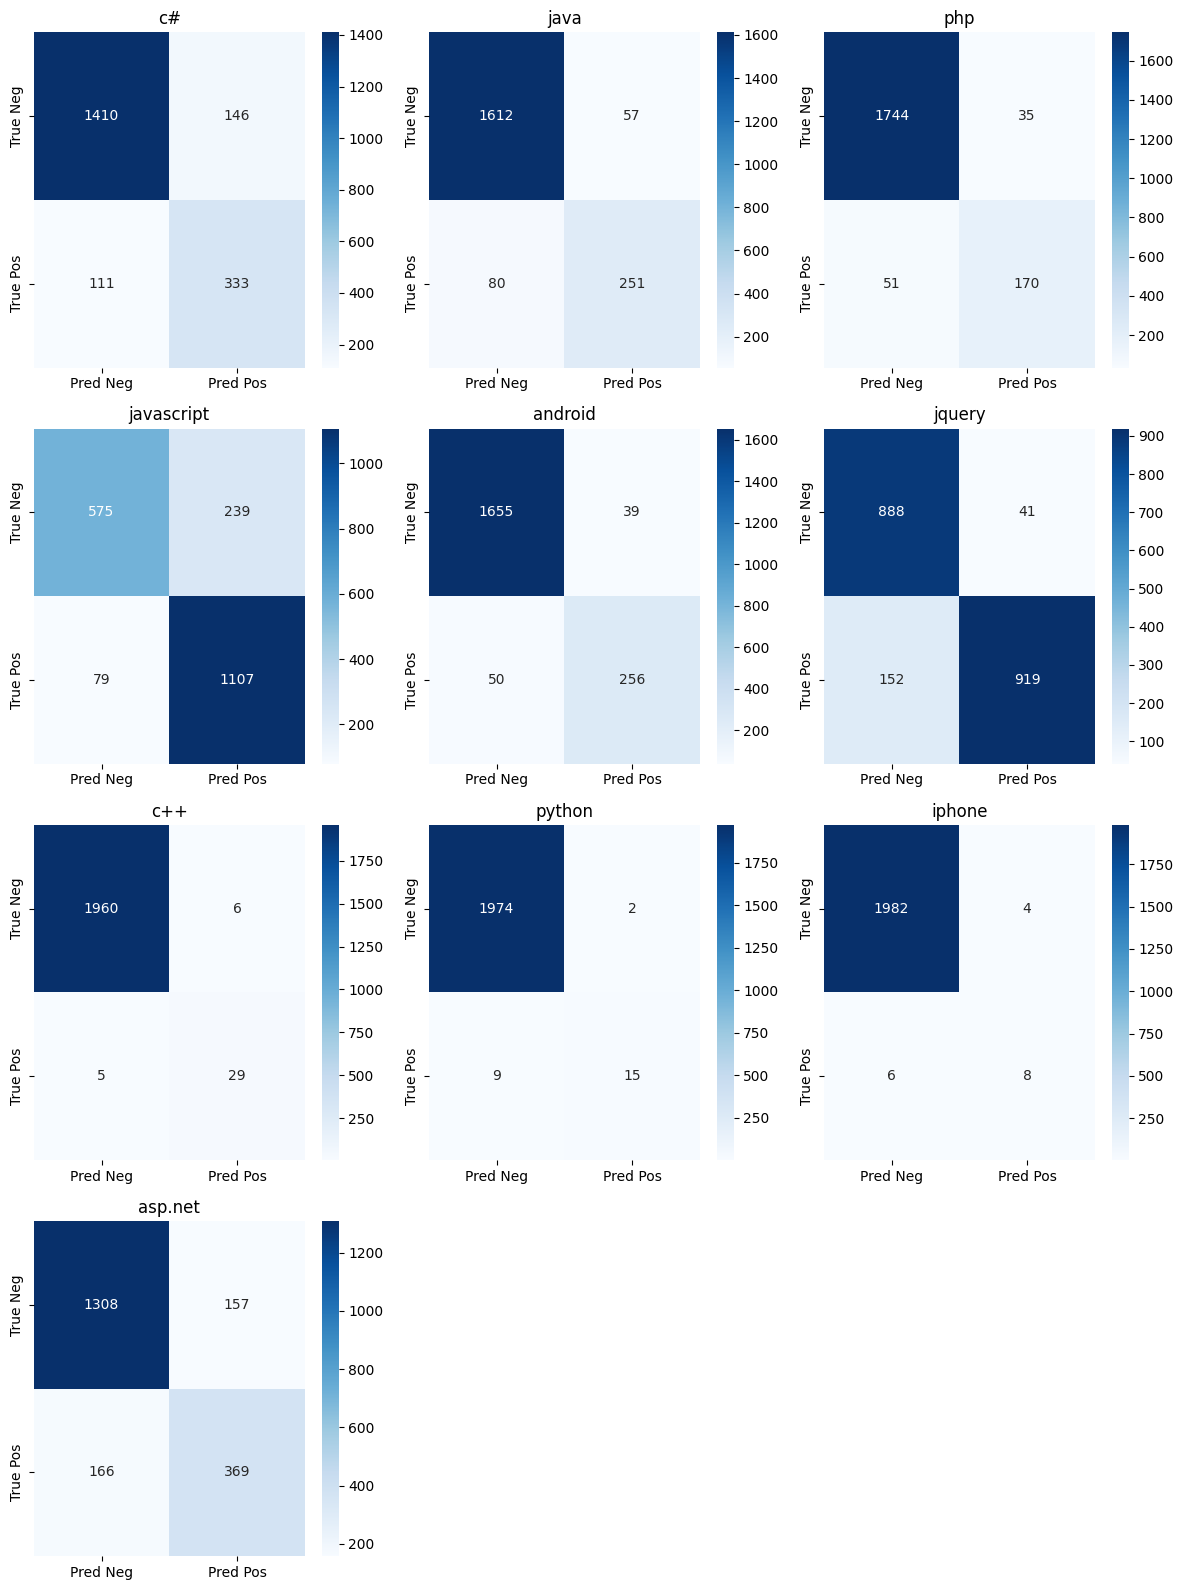

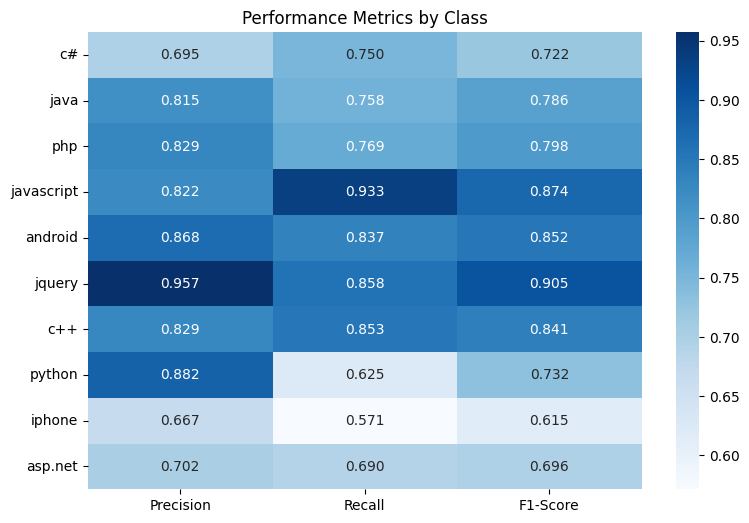

<Figure size 1200x533.333 with 0 Axes>

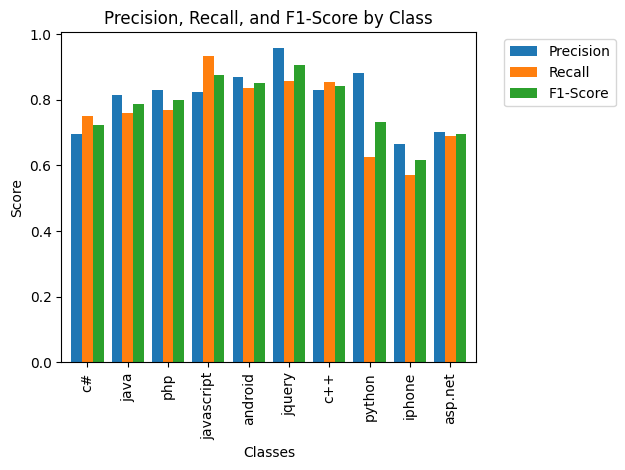

{'macro_avg': {'precision': 0.8066038763195813,
  'recall': 0.7644695716234338,
  'f1': 0.7819820539250031},
 'per_class': {'Precision': {'c#': 0.6951983298538622,
   'java': 0.814935064935065,
   'php': 0.8292682926829268,
   'javascript': 0.8224368499257058,
   'android': 0.8677966101694915,
   'jquery': 0.9572916666666667,
   'c++': 0.8285714285714286,
   'python': 0.8823529411764706,
   'iphone': 0.6666666666666666,
   'asp.net': 0.7015209125475285},
  'Recall': {'c#': 0.75,
   'java': 0.7583081570996979,
   'php': 0.7692307692307693,
   'javascript': 0.9333895446880269,
   'android': 0.8366013071895425,
   'jquery': 0.8580765639589168,
   'c++': 0.8529411764705882,
   'python': 0.625,
   'iphone': 0.5714285714285714,
   'asp.net': 0.6897196261682244},
  'F1-Score': {'c#': 0.7215601300108342,
   'java': 0.7856025039123631,
   'php': 0.7981220657276995,
   'javascript': 0.8744075829383886,
   'android': 0.8519134775374376,
   'jquery': 0.9049729197439685,
   'c++': 0.840579710144927

In [57]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=class_names, figsize=(12, 8))

<font color = 'indianred'> *Get best checkpoint*</font>


In [58]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 240.


#  <font color = 'indianred'> **7. Performance on Test Set** </font>
For test set evaluation, we will perfrom following steps:



In [59]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/bert_imb/checkpoint-240'

In [60]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [61]:
test_set_tokenized = test_split.map(tokenize_fn, batched=True)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [62]:
test_set_tokenized

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})

In [63]:
test_set_tokenized.set_format(type='torch')
test_set_tokenized = (test_set_tokenized
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

<font color = 'indianred'>*Training Arguments*</font>

In [64]:
training_args = TrainingArguments(
    seed = 42,
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

<font color = 'indianred'>*Instantiate Trainer*</font>

In [65]:
from functools import partial

In [66]:
partial??

In [67]:
compute_metrics_fn = partial(compute_metrics, thresholds=optimal_thresholds)

In [68]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics_fn,
    tokenizer=tokenizer,
)

<ipython-input-68-b7cbf9c7164a>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


<font color = 'indianred'>*Evaluate using Trainer*</font>

In [69]:
test_results= trainer.evaluate()

In [70]:
test_results

{'eval_loss': 0.7383702397346497,
 'eval_model_preparation_time': 0.0017,
 'eval_f1_micro': 0.8147355912061794,
 'eval_f1_macro': 0.7654557391363032,
 'eval_accuracy_label': 0.92205,
 'eval_accuracy_all': 0.616,
 'eval_runtime': 6.5633,
 'eval_samples_per_second': 304.727,
 'eval_steps_per_second': 2.438}

In [71]:
wandb.log({"test_f1_macro": test_results["eval_f1_macro"], "test_loss": test_results["eval_loss"], "test_accuracy": test_results["eval_accuracy_all"]})

<font color = 'indianred'>*Confusion Matrix*</font>

In [72]:
test_output = trainer.predict(test_set_tokenized)

In [73]:
test_preds = np.array((test_output.predictions > 0).astype(int))
test_labels = np.array(test_output.label_ids.astype(int))


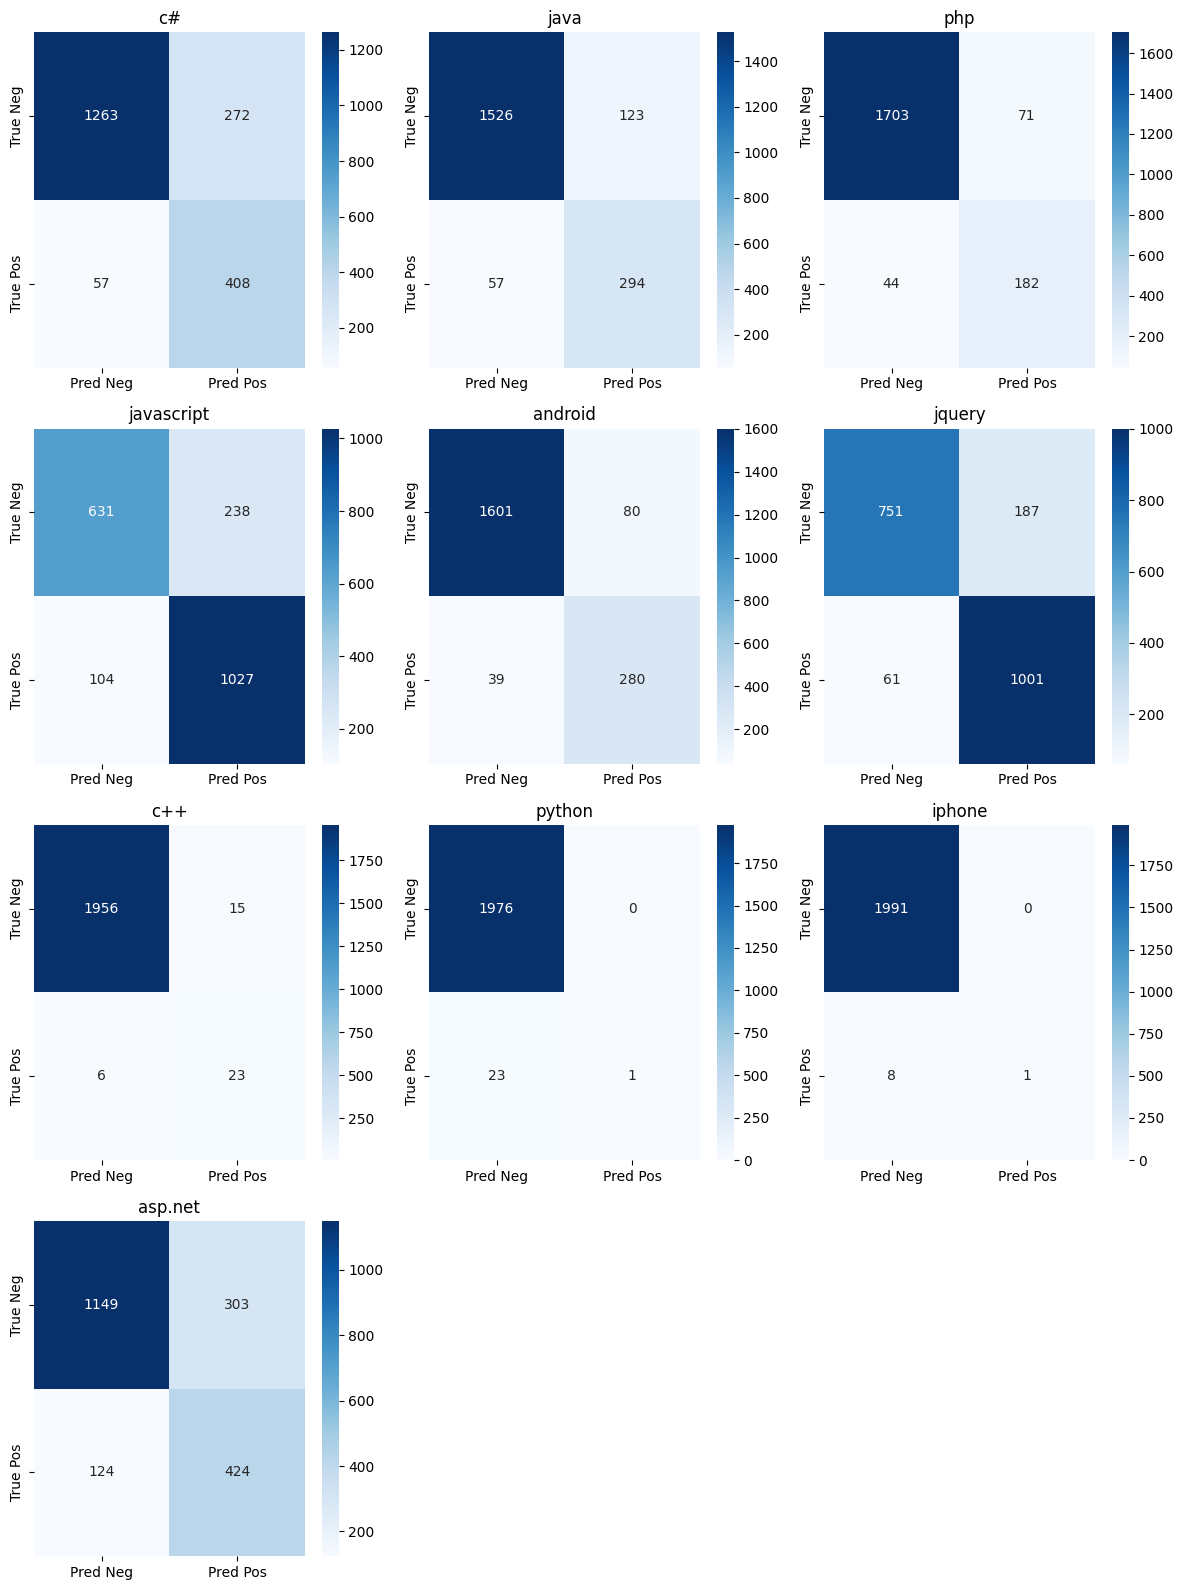

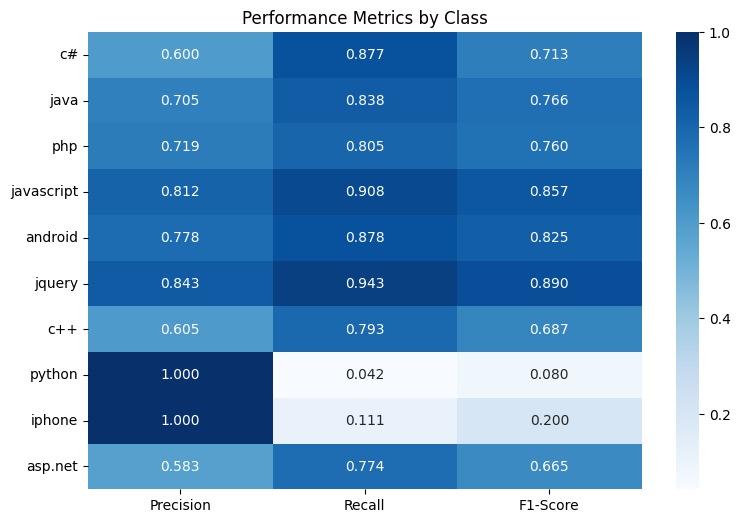

<Figure size 1200x533.333 with 0 Axes>

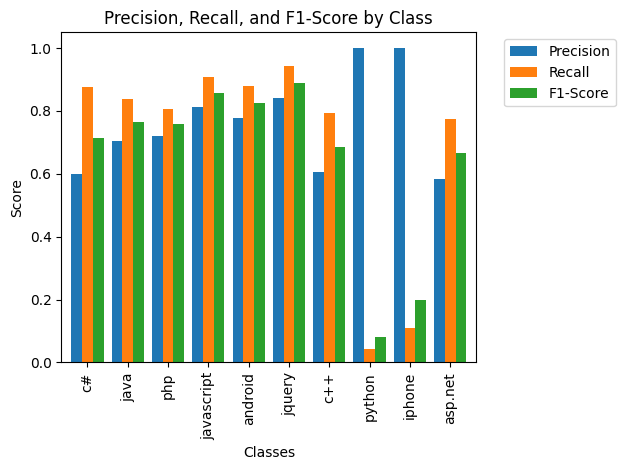

{'macro_avg': {'precision': 0.7645113502945947,
  'recall': 0.6968289909742715,
  'f1': 0.6441652600871275},
 'per_class': {'Precision': {'c#': 0.6,
   'java': 0.7050359712230215,
   'php': 0.7193675889328063,
   'javascript': 0.8118577075098814,
   'android': 0.7777777777777778,
   'jquery': 0.8425925925925926,
   'c++': 0.6052631578947368,
   'python': 1.0,
   'iphone': 1.0,
   'asp.net': 0.5832187070151307},
  'Recall': {'c#': 0.8774193548387097,
   'java': 0.8376068376068376,
   'php': 0.8053097345132744,
   'javascript': 0.9080459770114943,
   'android': 0.877742946708464,
   'jquery': 0.9425612052730696,
   'c++': 0.7931034482758621,
   'python': 0.041666666666666664,
   'iphone': 0.1111111111111111,
   'asp.net': 0.7737226277372263},
  'F1-Score': {'c#': 0.7126637554585152,
   'java': 0.765625,
   'php': 0.7599164926931107,
   'javascript': 0.8572621035058431,
   'android': 0.8247422680412371,
   'jquery': 0.8897777777777778,
   'c++': 0.6865671641791045,
   'python': 0.08,
   '

In [74]:
multilabel_evaluation(y_true=test_labels, y_pred=test_preds, class_names=class_names, figsize=(12, 8))

In [75]:
wandb.finish()

eval/accuracy_all,▂▁▂▁▄▄▅▆▆████
eval/accuracy_label,▃▁▂▄▆▆▇▇▇████
eval/f1_macro,▁▁▃▄▅▆▆▇▇████
eval/f1_micro,▁▁▂▄▆▆▆▇▇████
eval/loss,██▇▆▅▄▃▃▂▂▁▁▁
eval/runtime,█▃▅▂▁▁▁▂▂▂▃▃▃
eval/samples_per_second,▁▆▄▇███▇▇▇▆▆▆
eval/steps_per_second,▁▆▄▇███▇▇▇▆▆▆
eval_accuracy,▁
eval_f1_macro,▁
eval_loss,▁


# <Font color = 'indianred'> **8. Model Inference**



In [76]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=0,
    return_all_scores=True,
    function_to_apply='sigmoid')

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


<font color = 'indianred'> **Test the pipeline on a single example**

In [77]:
sample = test_split['text'][0]
preds = custom_pipeline(sample)
preds


[[{'label': 'c#', 'score': 0.7435815334320068},
  {'label': 'java', 'score': 0.5055711269378662},
  {'label': 'php', 'score': 0.24701623618602753},
  {'label': 'javascript', 'score': 0.34982115030288696},
  {'label': 'android', 'score': 0.42040637135505676},
  {'label': 'jquery', 'score': 0.3307848870754242},
  {'label': 'c++', 'score': 0.30658552050590515},
  {'label': 'python', 'score': 0.17547732591629028},
  {'label': 'iphone', 'score': 0.15533757209777832},
  {'label': 'asp.net', 'score': 0.7596521973609924}]]

In [78]:
def get_positive_labels(pipeline_output, optimal_thresholds, label2id=None):

   positive_labels = []

   for pred_set in pipeline_output:
       # Get scores for all labels
       scores = [pred['score'] for pred in pred_set]
       labels = [pred['label'] for pred in pred_set]

       # Get positions where score > threshold for that label
       sample_positives = [
           label for label, score, threshold in zip(labels, scores, optimal_thresholds)
           if score >= threshold
       ]

       positive_labels.append(sample_positives)

   return positive_labels


In [79]:
results = get_positive_labels(preds, optimal_thresholds)
results

[['c#', 'asp.net']]

<font color = 'indianred'> **Test the pipeline on a large dataset**

In [80]:
preds = custom_pipeline(test_split['text'], truncation=True)

In [81]:
preds[0:3]


[[{'label': 'c#', 'score': 0.7435815334320068},
  {'label': 'java', 'score': 0.5055711269378662},
  {'label': 'php', 'score': 0.24701623618602753},
  {'label': 'javascript', 'score': 0.34982115030288696},
  {'label': 'android', 'score': 0.42040637135505676},
  {'label': 'jquery', 'score': 0.3307848870754242},
  {'label': 'c++', 'score': 0.30658552050590515},
  {'label': 'python', 'score': 0.17547732591629028},
  {'label': 'iphone', 'score': 0.15533757209777832},
  {'label': 'asp.net', 'score': 0.7596521973609924}],
 [{'label': 'c#', 'score': 0.7946690917015076},
  {'label': 'java', 'score': 0.43933936953544617},
  {'label': 'php', 'score': 0.2684176564216614},
  {'label': 'javascript', 'score': 0.40129485726356506},
  {'label': 'android', 'score': 0.33942097425460815},
  {'label': 'jquery', 'score': 0.33510300517082214},
  {'label': 'c++', 'score': 0.32393285632133484},
  {'label': 'python', 'score': 0.18641342222690582},
  {'label': 'iphone', 'score': 0.18253162503242493},
  {'label':

In [82]:
results = get_positive_labels(preds, optimal_thresholds)
results[0:3]

[['c#', 'asp.net'], ['c#', 'asp.net'], ['php', 'javascript']]